In [1]:
# 0) LIBRARIES & INSTALL
!pip install datasets gensim -q

import os
import json
import random
from collections import Counter

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import gensim.downloader as api

from google.colab import drive


# 1) GOOGLE DRIVE MOUNT
drive.mount('/content/drive')

# Output directory for Question 5
OUT_DIR = "/content/drive/MyDrive/TakeHome543/Question5"
os.makedirs(OUT_DIR, exist_ok=True)


# 2) REPRODUCIBILITY
def set_seed(seed: int = 42):
    """
    Sets seeds for Python, NumPy and PyTorch to ensure deterministic behavior.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# =====================
# 3) HYPERPARAMETERS
# =====================
MAX_VOCAB_SIZE = 20000
MAX_LEN = 256
EMBED_DIM = 300
HIDDEN_SIZE = 128
NUM_LAYERS = 1
BATCH_SIZE = 64
EPOCHS = 3
LR = 1e-3


# 4) TOKENIZER

def tokenizer(text: str):
    """
    Very simple whitespace tokenizer (lowercased).
    """
    return text.lower().split()


# 5) DATASET CLASS

class IMDBStaticDataset(Dataset):
    def __init__(self, hf_split, vocab, max_len: int = 256):
        self.data = hf_split
        self.vocab = vocab
        self.max_len = max_len
        self.unk_id = vocab["<UNK>"]
        self.pad_id = vocab["<PAD>"]

    def __len__(self):
        return len(self.data)

    def encode(self, text: str):
        tokens = tokenizer(text)
        ids = [self.vocab.get(tok, self.unk_id) for tok in tokens]

        # Truncate
        if len(ids) > self.max_len:
            ids = ids[: self.max_len]

        # Pad
        if len(ids) < self.max_len:
            ids = ids + [self.pad_id] * (self.max_len - len(ids))

        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        example = self.data[idx]
        text = example["text"]
        label = example["label"]  # 0 or 1

        x = self.encode(text)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


# 6) MODEL: BiGRU (STATIC GLOVE)

class BiGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers,
                 embedding_matrix=None, freeze_emb=True):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        if freeze_emb:
            self.embedding.weight.requires_grad = False

        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )

        self.fc = nn.Linear(2 * hidden_size, 2)

    def forward(self, x):
        emb = self.embedding(x)          # (B, T, E)
        output, h_n = self.gru(emb)      # h_n: (num_layers*2, B, H)

        # Last layer forward + backward
        h_forward = h_n[-2, :, :]
        h_backward = h_n[-1, :, :]
        h_cat = torch.cat([h_forward, h_backward], dim=-1)  # (B, 2H)

        logits = self.fc(h_cat)          # (B, 2)
        return logits

    def encode(self, x):
        """
        Returns latent representation h_cat (without classification head).
        """
        emb = self.embedding(x)
        output, h_n = self.gru(emb)

        h_forward = h_n[-2, :, :]
        h_backward = h_n[-1, :, :]
        h_cat = torch.cat([h_forward, h_backward], dim=-1)
        return h_cat

# 7) TRAIN / EVAL HELPERS

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(batch_y.cpu().numpy().tolist())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, acc, macro_f1

def save_json(data, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(data, f, indent=4)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 93.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [2]:
# 8) DATA PREPARATION + VOCAB + GLOVE + TRAINING

set_seed(42)

print("Loading IMDb dataset...")
ds = load_dataset("imdb")

# Train/val split
split = ds["train"].train_test_split(test_size=0.15, seed=42)
train_ds_hf = split["train"]
val_ds_hf = split["test"]
test_ds_hf = ds["test"]

print("Train:", len(train_ds_hf), "Val:", len(val_ds_hf), "Test:", len(test_ds_hf))

# Build vocabulary from training split
print("Building vocabulary...")
counter = Counter()
for example in train_ds_hf:
    counter.update(tokenizer(example["text"]))

most_common = counter.most_common(MAX_VOCAB_SIZE - 2)
vocab = {"<PAD>": 0, "<UNK>": 1}
for i, (word, freq) in enumerate(most_common, start=2):
    vocab[word] = i

vocab_size = len(vocab)
print("Vocab size:", vocab_size)

# Load GloVe embeddings
print("Loading GloVe embeddings (glove-wiki-gigaword-300)...")
glove = api.load("glove-wiki-gigaword-300")

embedding_matrix = np.zeros((vocab_size, EMBED_DIM), dtype=np.float32)
oov_count = 0

for word, idx in vocab.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMBED_DIM,))
        oov_count += 1

print(f"OOV words: {oov_count} / {vocab_size}")

# Torch Dataset & DataLoader
train_dataset = IMDBStaticDataset(train_ds_hf, vocab, max_len=MAX_LEN)
val_dataset = IMDBStaticDataset(val_ds_hf, vocab, max_len=MAX_LEN)
test_dataset = IMDBStaticDataset(test_ds_hf, vocab, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Initialize Static BiGRU model
print("\n===== Training Static BiGRU (GloVe) =====")
bigru = BiGRU(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    embedding_matrix=embedding_matrix,
    freeze_emb=True,
).to(DEVICE)

optimizer_bigru = torch.optim.Adam(
    filter(lambda p: p.requires_grad, bigru.parameters()),
    lr=LR
)

logs = {
    "bigru_static": {
        "epochs": []
    }
}

best_val_f1 = 0.0
best_state_dict = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(bigru, train_loader, optimizer_bigru, criterion, DEVICE)
    val_loss, val_acc, val_f1 = evaluate(bigru, val_loader, criterion, DEVICE)

    print(f"[BiGRU] Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val Macro-F1: {val_f1:.4f}")

    logs["bigru_static"]["epochs"].append({
        "epoch": epoch,
        "train_loss": float(train_loss),
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "val_macro_f1": float(val_f1),
    })

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state_dict = bigru.state_dict()

# Use best validation F1 weights if available
if best_state_dict is not None:
    bigru.load_state_dict(best_state_dict)

# Test performance
test_loss, test_acc, test_f1 = evaluate(bigru, test_loader, criterion, DEVICE)
print(f"\n[BiGRU] Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Macro-F1: {test_f1:.4f}")

logs["bigru_static"]["test"] = {
    "test_loss": float(test_loss),
    "test_acc": float(test_acc),
    "test_macro_f1": float(test_f1),
}

# Save logs + model + vocab
logs_path = os.path.join(OUT_DIR, "static_bigru_imdb_logs.json")
save_json(logs, logs_path)
print(f"Saved JSON logs to {logs_path}")

checkpoint_path = os.path.join(OUT_DIR, "static_bigru_imdb.pt")
torch.save({
    "model_state_dict": bigru.state_dict(),
    "vocab": vocab,
    "hyperparams": {
        "max_len": MAX_LEN,
        "embed_dim": EMBED_DIM,
        "hidden_size": HIDDEN_SIZE,
        "num_layers": NUM_LAYERS,
    }
}, checkpoint_path)
print(f"Saved model checkpoint to {checkpoint_path}")


Loading IMDb dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train: 21250 Val: 3750 Test: 25000
Building vocabulary...
Vocab size: 20000
Loading GloVe embeddings (glove-wiki-gigaword-300)...
[==================================================] 100.0% 376.1/376.1MB downloaded
OOV words: 6778 / 20000

===== Training Static BiGRU (GloVe) =====
[BiGRU] Epoch 1/3 | Train Loss: 0.5730 | Val Loss: 0.5488 | Val Acc: 0.7275 | Val Macro-F1: 0.7139
[BiGRU] Epoch 2/3 | Train Loss: 0.3967 | Val Loss: 0.3741 | Val Acc: 0.8331 | Val Macro-F1: 0.8330
[BiGRU] Epoch 3/3 | Train Loss: 0.3346 | Val Loss: 0.3620 | Val Acc: 0.8384 | Val Macro-F1: 0.8376

[BiGRU] Test Loss: 0.3466 | Test Acc: 0.8452 | Test Macro-F1: 0.8449
Saved JSON logs to /content/drive/MyDrive/TakeHome543/Question5/static_bigru_imdb_logs.json
Saved model checkpoint to /content/drive/MyDrive/TakeHome543/Question5/static_bigru_imdb.pt


In [3]:

# 9) PREDICTION + ENTROPY HELPER

def text_to_tensor(text, vocab, max_len=MAX_LEN):
    tokens = tokenizer(text)
    ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]
    if len(ids) > max_len:
        ids = ids[:max_len]
    if len(ids) < max_len:
        ids = ids + [vocab["<PAD>"]] * (max_len - len(ids))
    x = torch.tensor(ids, dtype=torch.long).unsqueeze(0)  # (1, T)
    return x

def predict_with_metadata(model, text, vocab, max_len=MAX_LEN, device=DEVICE):
    """
    Runs the Static BiGRU model on a single text and returns:
    - logits
    - probabilities
    - predicted label
    - entropy (uncertainty)
    """
    model.eval()
    x = text_to_tensor(text, vocab, max_len=max_len).to(device)

    with torch.no_grad():
        logits = model(x)               # (1, 2)
        probs = F.softmax(logits, dim=-1)[0]  # (2,)

    pred_label = torch.argmax(probs).item()
    entropy = -torch.sum(probs * torch.log(probs + 1e-12)).item()

    return {
        "logits": logits.cpu().numpy().tolist(),
        "probs": probs.cpu().numpy().tolist(),
        "pred_label": pred_label,
        "entropy": entropy,
    }

# Quick sanity check: run on a few test samples
print("\n=== Sanity check on a few test examples ===")
for i in range(3):
    ex = test_ds_hf[i]
    text = ex["text"]
    gold = ex["label"]
    meta = predict_with_metadata(bigru, text, vocab, max_len=MAX_LEN, device=DEVICE)

    print(f"\nExample {i}")
    print("Gold label:", gold)
    print("Pred label:", meta["pred_label"])
    print("Probs:", meta["probs"])
    print("Entropy:", meta["entropy"])
    print("Text snippet:", text[:300].replace("\n", " "))



=== Sanity check on a few test examples ===

Example 0
Gold label: 0
Pred label: 0
Probs: [0.9588784575462341, 0.041121553629636765]
Entropy: 0.17149226367473602
Text snippet: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, C

Example 1
Gold label: 0
Pred label: 0
Probs: [0.8626604080200195, 0.13733963668346405]
Entropy: 0.4001045525074005
Text snippet: Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled bu

Example 2
Gold label: 0
Pred label: 0
Probs: [0.9460894465446472, 0.0539105087518692]
Entr

In [4]:

# 10) FULL TEST PREDICTIONS + UNCERTAINTY + CALIBRATION


from tqdm import tqdm

def collect_test_predictions(model, hf_split, vocab, max_len=MAX_LEN, device=DEVICE):
    """
    Runs the model on the full test split and returns a list of per-example dicts:
    - index
    - text
    - gold_label
    - pred_label
    - probs
    - entropy
    - correct (0/1)
    """
    results = []
    model.eval()

    for i in tqdm(range(len(hf_split)), desc="Collecting test predictions"):
        ex = hf_split[i]
        text = ex["text"]
        gold = ex["label"]

        meta = predict_with_metadata(model, text, vocab, max_len=max_len, device=device)
        pred = meta["pred_label"]
        probs = meta["probs"]
        entropy = meta["entropy"]
        correct = int(pred == gold)

        # confidence: max probability
        confidence = float(max(probs))

        results.append({
            "index": i,
            "text": text,
            "gold_label": int(gold),
            "pred_label": int(pred),
            "probs": probs,
            "entropy": float(entropy),
            "confidence": confidence,
            "correct": correct,
        })

    return results

def compute_calibration_bins(results, n_bins=10):
    """
    Computes simple calibration statistics:
    - splits by confidence into bins
    - for each bin: avg_confidence, accuracy, count
    """
    bins = [[] for _ in range(n_bins)]

    for r in results:
        conf = r["confidence"]
        # put into bin [0, 1]
        bin_idx = min(int(conf * n_bins), n_bins - 1)
        bins[bin_idx].append(r)

    bin_stats = []
    for b in range(n_bins):
        bucket = bins[b]
        if len(bucket) == 0:
            bin_stats.append({
                "bin": b,
                "range": [b / n_bins, (b + 1) / n_bins],
                "avg_confidence": None,
                "accuracy": None,
                "count": 0,
            })
            continue

        confs = [ex["confidence"] for ex in bucket]
        corrects = [ex["correct"] for ex in bucket]
        avg_conf = float(np.mean(confs))
        acc = float(np.mean(corrects))

        bin_stats.append({
            "bin": b,
            "range": [b / n_bins, (b + 1) / n_bins],
            "avg_confidence": avg_conf,
            "accuracy": acc,
            "count": len(bucket),
        })

    return bin_stats

# Run collection on full test split
test_results = collect_test_predictions(bigru, test_ds_hf, vocab, max_len=MAX_LEN, device=DEVICE)

# Compute calibration stats
calibration_stats = compute_calibration_bins(test_results, n_bins=10)

#Global summary
overall_acc = float(np.mean([r["correct"] for r in test_results]))
overall_entropy_mean = float(np.mean([r["entropy"] for r in test_results]))
overall_entropy_std = float(np.std([r["entropy"] for r in test_results]))

summary = {
    "overall_accuracy": overall_acc,
    "overall_entropy_mean": overall_entropy_mean,
    "overall_entropy_std": overall_entropy_std,
}

print("Overall test accuracy (from prediction scan):", overall_acc)
print("Mean entropy:", overall_entropy_mean, "Std:", overall_entropy_std)

print("\nCalibration bins (confidence range, avg_conf, accuracy, count):")
for b in calibration_stats:
    print(f"Bin {b['bin']} | range={b['range']} | "
          f"avg_conf={b['avg_confidence']} | acc={b['accuracy']} | count={b['count']}")

#Save everything to JSON
preds_path = os.path.join(OUT_DIR, "static_bigru_imdb_test_predictions.json")
calib_path = os.path.join(OUT_DIR, "static_bigru_imdb_calibration.json")
summary_path = os.path.join(OUT_DIR, "static_bigru_imdb_uncertainty_summary.json")

save_json(test_results, preds_path)
save_json({
    "calibration_bins": calibration_stats,
    "summary": summary
}, calib_path)
save_json(summary, summary_path)

print(f"\nSaved test predictions to {preds_path}")
print(f"Saved calibration stats to {calib_path}")
print(f"Saved summary to {summary_path}")


Overall test accuracy (from prediction scan): 0.84524
Mean entropy: 0.3347037823159993 Std: 0.2157218468451638

Calibration bins (confidence range, avg_conf, accuracy, count):
Bin 0 | range=[0.0, 0.1] | avg_conf=None | acc=None | count=0
Bin 1 | range=[0.1, 0.2] | avg_conf=None | acc=None | count=0
Bin 2 | range=[0.2, 0.3] | avg_conf=None | acc=None | count=0
Bin 3 | range=[0.3, 0.4] | avg_conf=None | acc=None | count=0
Bin 4 | range=[0.4, 0.5] | avg_conf=None | acc=None | count=0
Bin 5 | range=[0.5, 0.6] | avg_conf=0.5489568875143023 | acc=0.5288825757575758 | count=2112
Bin 6 | range=[0.6, 0.7] | avg_conf=0.6519217970795798 | acc=0.6334390575441776 | count=2207
Bin 7 | range=[0.7, 0.8] | avg_conf=0.7523888969012377 | acc=0.7226590421729807 | count=2798
Bin 8 | range=[0.8, 0.9] | avg_conf=0.8561501646679296 | acc=0.8330712199505729 | count=4451
Bin 9 | range=[0.9, 1.0] | avg_conf=0.960387499538151 | acc=0.9593508040500298 | count=13432

Saved test predictions to /content/drive/MyDrive

In [5]:

# 11) FAILURE CASE SELECTION


# Filter wrong predictions
wrong = [r for r in test_results if r["correct"] == 0]

# Sort by entropy (descending) -> high-uncertainty wrong cases
high_entropy_wrong = sorted(wrong, key=lambda r: r["entropy"], reverse=True)

# Sort by entropy (ascending) -> low-uncertainty wrong cases (overconfident errors)
low_entropy_wrong = sorted(wrong, key=lambda r: r["entropy"])

N = 5

print(f"Total wrong predictions: {len(wrong)}")

print("\n=== Top-5 HIGH-ENTROPY wrong predictions (uncertain & wrong) ===")
for i, ex in enumerate(high_entropy_wrong[:N], start=1):
    print(f"\n[High-entropy wrong #{i}]")
    print(f"Index: {ex['index']}")
    print(f"Gold label: {ex['gold_label']} | Pred label: {ex['pred_label']}")
    print(f"Probs: {ex['probs']}")
    print(f"Entropy: {ex['entropy']}")
    print("Text snippet:", ex["text"][:400].replace("\n", " "))

print("\n=== Top-5 LOW-ENTROPY wrong predictions (overconfident & wrong) ===")
for i, ex in enumerate(low_entropy_wrong[:N], start=1):
    print(f"\n[Low-entropy wrong #{i}]")
    print(f"Index: {ex['index']}")
    print(f"Gold label: {ex['gold_label']} | Pred label: {ex['pred_label']}")
    print(f"Probs: {ex['probs']}")
    print(f"Entropy: {ex['entropy']}")
    print("Text snippet:", ex["text"][:400].replace("\n", " "))

# Optionally save them to JSON for later use in LaTeX/report
failure_cases_path = os.path.join(OUT_DIR, "static_bigru_imdb_failure_cases.json")
failure_cases_obj = {
    "high_entropy_wrong_top5": high_entropy_wrong[:N],
    "low_entropy_wrong_top5": low_entropy_wrong[:N],
}
save_json(failure_cases_obj, failure_cases_path)
print(f"\nSaved failure case candidates to {failure_cases_path}")


Total wrong predictions: 3869

=== Top-5 HIGH-ENTROPY wrong predictions (uncertain & wrong) ===

[High-entropy wrong #1]
Index: 7671
Gold label: 0 | Pred label: 1
Probs: [0.49964332580566406, 0.5003566145896912]
Entropy: 0.6931469440460205
Text snippet: The film has no connection with the real life in Bosnia in those days. Should be more realistic and shows the viewer real traumas that were happening to common people during the war. Please see some films of Yugoslav authors (Emir Kusturica, Ljubisa Samardzic,...e.g. Bure baruta( A barrel of powder), Tito i ja (Tito and me), Lepa sela lepo gore (Beautiful Villages burn Beautiful), etc... Just this

[High-entropy wrong #2]
Index: 13032
Gold label: 1 | Pred label: 0
Probs: [0.5003697872161865, 0.49963024258613586]
Entropy: 0.6931469440460205
Text snippet: If you want to see a true thriller, rent this!!! It's not from the director or screenwriter of "Scream", doesn't feature overacting, overpaid "TV" actors passing off as "stars", and is n

In [10]:
def integrated_gradients_for_text(text, target_label, vocab, max_len=MAX_LEN,
                                  steps=50, device=DEVICE):


    bigru.train()

    # 1) Token IDs ve tokens
    input_ids, tokens = text_to_ids(text, vocab, max_len=max_len)
    input_ids = input_ids.to(device)

    # 2) Input embedding
    emb_layer = bigru.embedding
    input_emb = emb_layer(input_ids)  # (1, T, E)

    baseline = torch.zeros_like(input_emb).to(device)


    scaled_inputs = [
        baseline + (float(i) / steps) * (input_emb - baseline)
        for i in range(1, steps + 1)
    ]

    # 4) Gradient biriktirme
    total_grads = torch.zeros_like(input_emb).to(device)

    for scaled in scaled_inputs:
        scaled = scaled.clone().detach().requires_grad_(True)

        logits = forward_pass_emb(scaled)
        logit = logits[0, target_label]

        bigru.zero_grad()
        if scaled.grad is not None:
            scaled.grad.zero_()

        logit.backward(retain_graph=True)
        grads = scaled.grad.detach()
        total_grads += grads

    avg_grads = total_grads / steps

    # 5) IG = (input - baseline) * avg_grad
    attributions = (input_emb - baseline) * avg_grads
    token_attribs = attributions.squeeze(0).sum(dim=1).detach().cpu().numpy()

    # convergence metriği
    delta = float(np.linalg.norm(token_attribs))

    bigru.eval()

    return tokens, token_attribs, delta



In [8]:
def plot_token_attributions(tokens, scores, title, save_path=None, max_tokens=40):
    """
    Token bazlı attribution skorlarını yatay bar grafiği olarak çizer.
    Negatifler kırmızı, pozitifler mavi.
    """
    tokens = tokens[:max_tokens]
    scores = scores[:max_tokens]

    plt.figure(figsize=(12, 6))
    bar_colors = ["red" if s < 0 else "blue" for s in scores]

    y_pos = np.arange(len(tokens))
    plt.barh(y_pos, scores, color=bar_colors)
    plt.yticks(y_pos, tokens)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved figure:", save_path)

    plt.show()

def explain_example(example, name="example"):
    """
    test_results içinden bir örnek alır, Integrated Gradients hesaplar,
    heatmap üretir ve kaydeder.
    """
    text = example["text"]
    gold = example["gold_label"]
    pred = example["pred_label"]

    tokens, scores, delta = integrated_gradients_for_text(
        text=text,
        target_label=pred,
        vocab=vocab,
        max_len=MAX_LEN,
        steps=50,
        device=DEVICE
    )

    fig_path = os.path.join(FIG_DIR, f"ig_{name}.png")

    plot_token_attributions(
        tokens,
        scores,
        title=f"Integrated Gradients (Pred={pred}, Gold={gold})",
        save_path=fig_path
    )

    return {
        "tokens": tokens,
        "scores": scores.tolist(),
        "delta": delta,
        "fig_path": fig_path
    }



=== IG Explanation: High-Entropy Wrong Example ===
Saved figure: /content/drive/MyDrive/TakeHome543/Question5/figures/ig_high_entropy_wrong_0.png


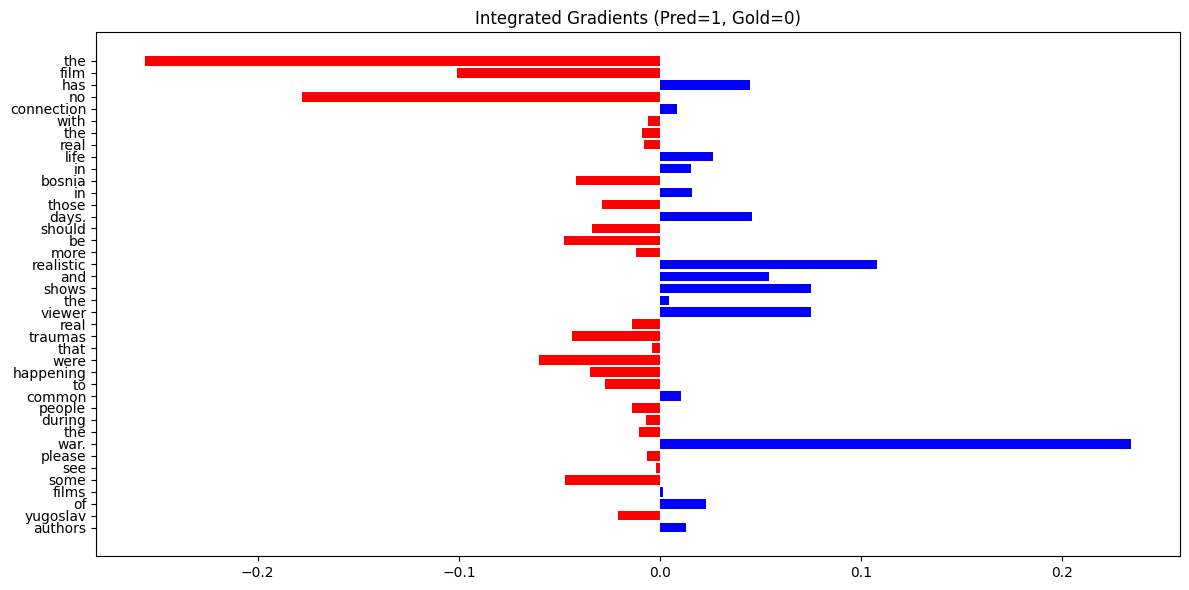


=== IG Explanation: Low-Entropy Wrong Example ===
Saved figure: /content/drive/MyDrive/TakeHome543/Question5/figures/ig_low_entropy_wrong_0.png


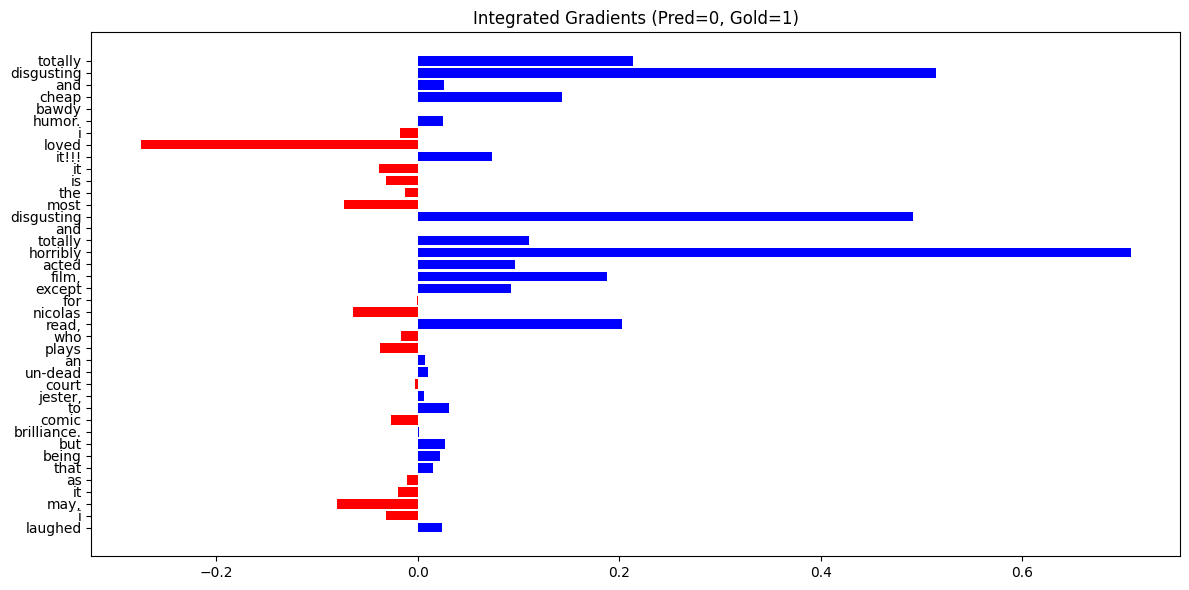


Saved IG metadata to: /content/drive/MyDrive/TakeHome543/Question5/static_bigru_ig_metadata.json
Figures directory: /content/drive/MyDrive/TakeHome543/Question5/figures


In [11]:

high_ex = high_entropy_wrong[0]
low_ex = low_entropy_wrong[0]

print("\n=== IG Explanation: High-Entropy Wrong Example ===")
ig_high = explain_example(high_ex, name="high_entropy_wrong_0")

print("\n=== IG Explanation: Low-Entropy Wrong Example ===")
ig_low = explain_example(low_ex, name="low_entropy_wrong_0")

exp_meta_path = os.path.join(OUT_DIR, "static_bigru_ig_metadata.json")
save_json({
    "high_entropy_wrong_0": ig_high,
    "low_entropy_wrong_0": ig_low
}, exp_meta_path)

print("\nSaved IG metadata to:", exp_meta_path)
print("Figures directory:", FIG_DIR)
